In [ ]:
import torch
from nd_scaffold import GridModule

mod = GridModule(shape=(3,3,5), device='cuda:0', T=0.1)

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())

mod.shift(torch.tensor([1,0,0], device='cuda:0'))

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())



In [ ]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
import os


def test_mnist(num_imgs=1, prefix="", relu_theta=0.5, sparsity=0.1, N_h=400, T=0.01):
    import torchvision
    from torchvision import transforms

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float().to("cuda")[:num_imgs]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    shapes = [(3, 3, 5), (4, 4, 7)]
    velocities = torch.tile(torch.tensor([[1,1,1]]), (l, 1)).to("cuda")

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
            T=T
        )
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    for i in range(1):
        original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
        noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
        recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
        print_imgs_side_by_side(
            original_img,
            noisy_img,
            recalled_img,
            out=f"{prefix}mnist_learned_{i}.png",
            captions=["original", "noisy", "recalled"],
            title="Learned",
        )

    similarity = torch.nn.functional.cosine_similarity(mnist_data, GS.recall(noisy_mnist))
    return similarity

test_mnist(11, sparsity=0.99, N_h=1000, prefix="", relu_theta=0.9)

module shapes:  [(3, 3, 5), (4, 4, 7)]
N_g     :  157
N_patts :  5040
N_h     :  200
H: tensor([[0.0000, 0.0000, 0.0154,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0120,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0073,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0058,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0287,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
G: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G_: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],

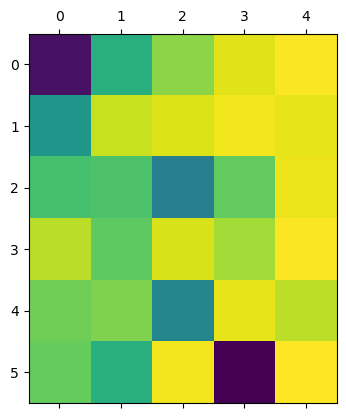

In [19]:
from matplotlib import pyplot as plt

temperatures = [0.001, 0.03, 0.01, 0.1, 0.3, 1]
N_h = [200, 400, 600, 800, 1000]

scores = np.zeros((len(temperatures), len(N_h)))

for i, T in enumerate(temperatures):
    for j, N in enumerate(N_h):
        scores[i, j] = test_mnist(11, sparsity=0.99, N_h=N, prefix=f"T_{T}_N_{N}_").mean().item()

print(scores)

fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap="viridis")

In [20]:
import pickle
with open("scores.pkl", "wb") as f:
    pickle.dump(scores, f)

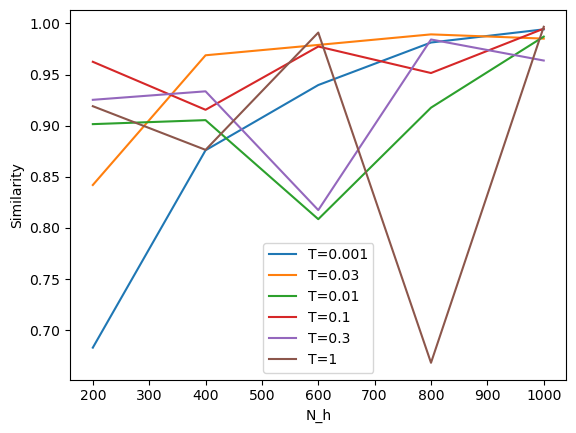

In [22]:
fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    ax.plot(N_h, scores[i], label=f"T={T}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()


In [31]:
import torch
velocities = []
def spacefillingcurve(modules,n):
        global velocities
        addcurves(n, modules)
        return velocities
        
def addcurves(n, mods):
        global velocities
        m = len(mods[1])
        if n!=0:
            ## gets the product of the modules for that dimension
            a = 1
            for modules in mods:
                a = a * modules[n]
            for i in range(a-1):
                ## in spot so add curve(n-1, mods)
                addcurves(n-1, mods)
                ## add a vector of dimesnion n, all 0 but a 1 in the nth dimension
                b = torch.zeros(m)
                b[n] = 1
                velocities.append(b)
            ## now add one last vector like a[n] + a[n+1]
            b = torch.zeros(m)
            # open the torch array and set the nth and n+1th dimension to 1
            b[n] = 1
            if n!=(m-1):
                b[n+1] = 1
            velocities.append(b)
        else:
            a=1
            for modules in mods:
                a = a * modules[n]
            for i in range(a-1):
                b = torch.zeros(m)
                b[1] = 1
                velocities.append(b)
            b = torch.zeros(m)
            b[n] = 1
            b[n+1] = 1
            velocities.append(b)
            
print(spacefillingcurve([[2,2,3], [3,3,5]],2))


[tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0